# Word Level Federated Text Generation with Stack Overflow
- Joel Stremmel
- 02-01-20

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).

**Notes:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/

**Data and Model References:**
- https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data
- https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb
- https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow
- https://www.tensorflow.org/tutorials/text/text_generation

**Environment Setup References:**
- https://www.tensorflow.org/install/gpu
- https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d
- https://www.tensorflow.org/install/source#tested_build_configurations
- https://anbasile.github.io/programming/2017/06/25/jupyter-venv/

### Environment Setup
Pip install these packages in the order listed.

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow-federated
# !pip uninstall tensorflow -y
# !pip install --upgrade tensorflow-gpu==2.0
# !pip install --upgrade nltk
# !pip install matplotlib
# !pip install nest_asyncio

### Imports

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

In [4]:
# from https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
from utils.dataset import construct_word_level_datasets, get_vocab, get_special_tokens

# from https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py
import utils.metrics as metrics

In [5]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_federated as tff

### Set Compatability Behavior

In [6]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [7]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: True
Build with GPU support: True
Num GPUs Available:  1


### Set Tensorflow to Use GPU

In [8]:
physical_devices = tf.config.experimental.list_physical_devices(device_type=None)
tf.config.experimental.set_memory_growth(physical_devices[-1], enable=True)
for device in physical_devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Test TFF

In [9]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model
**Note:** Ask Keith how he's been setting there for internal experiments.

In [10]:
VOCAB_SIZE = 10000
BATCH_SIZE = 8
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 2

NUM_ROUNDS = 100
NUM_TRAIN_CLIENTS = 10
UNIFORM_WEIGHTING = False

EMBEDDING_DIM = 100
RNN_UNITS = 256

### Load and Preprocess Word Level Datasets

In [11]:
train_data, val_data, test_data = construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Retrieve the Dataset Vocab

In [12]:
vocab = get_vocab(VOCAB_SIZE)

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [13]:
pad, oov, bos, eos = get_special_tokens(VOCAB_SIZE)

In [14]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [15]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [16]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [17]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

### Define Function to Build Model

In [18]:
def build_model():
    """
    Build model with architecture from: https://www.tensorflow.org/tutorials/text/text_generation.
    """

    model1_input = tf.keras.Input(shape=(None, ), # changed from MAX_SEQ_LENGTH
                                  name='model1_input')
    
    model1_embedding = tf.keras.layers.Embedding(input_dim=EXTENDED_VOCAB_SIZE,
                                                 output_dim=EMBEDDING_DIM,
                                                 mask_zero=True,
                                                 name='model1_embedding')(model1_input)
    
    model1_lstm = tf.keras.layers.LSTM(units=RNN_UNITS,
                                       return_sequences=True,
                                       recurrent_initializer='glorot_uniform',
                                       name='model1_lstm')(model1_embedding)
    
    model1_dense1 = tf.keras.layers.Dense(units=EMBEDDING_DIM)(model1_lstm)
    
    model1_dense2 = tf.keras.layers.Dense(units=EXTENDED_VOCAB_SIZE)(model1_dense1)
    
    final_model = tf.keras.Model(inputs=model1_input, outputs=model1_dense2)
                 
    return final_model

### Define the Text Generation Strategy

In [19]:
def generate_text(model, start_string):
    """
    Generate text by sampling from the model output distribution
    as in From https://www.tensorflow.org/tutorials/sequences/text_generation.
    """
    
    start_words = [word.lower() for word in start_string.split(' ')]

    num_generate = 50
    input_eval = [word2idx[word] for word in start_words]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    temperature = 1.0

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2word[predicted_id])

    return (' '.join(start_words) + ' '.join(text_generated))

### Load or Build the Model and Try Generating Some Text

In [20]:
keras_model = build_model()
print(generate_text(keras_model, "How are you today"))

how are you todaylookahead companion polls rare is ico auto-complete consumes nat phones generators developing convention reinstalled ror tuple lucky advice sheet1 tt gnu , 403 errors calendars tune countdown sufficient _session reproduces timed prerequisite 47 downloadable hooks spelling separated raspberry painted scrollable details marketplace holes unsure ctx galaxy searching midnight authenticate consult


### Define Evaluation Metrics for Training

In [21]:
def get_metrics():
    
    evaluation_metrics = [
        metrics.NumTokensCounter(name='num_tokens', masked_tokens=[pad]),
        metrics.NumTokensCounter(name='num_tokens_no_oov', masked_tokens=[pad, oov]),
        metrics.NumBatchesCounter(name='num_batches'),
        metrics.NumExamplesCounter(name='num_examples'),
        metrics.MaskedCategoricalAccuracy(name='accuracy', masked_tokens=[pad]),
        metrics.MaskedCategoricalAccuracy(name='accuracy_no_oov', masked_tokens=[pad, oov]),
        metrics.MaskedCategoricalAccuracy(name='accuracy_no_oov_no_eos', masked_tokens=[pad, oov, eos])
    ]
    
    return evaluation_metrics

### Define a Function to Compile the Model for Training

In [22]:
def compile_model(keras_model, evaluation_metrics):
    
    keras_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=evaluation_metrics)
    
    return keras_model

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [23]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


In [24]:
def model_fn():
    """
    Create TFF model from compiled Keras model and a sample batch.
    """
    
    keras_model = build_model()
    evaluation_metrics = get_metrics()
    
    compile_model(keras_model, evaluation_metrics)
    
    return tff.learning.from_compiled_keras_model(keras_model, sample_batch)

### Define Model History Tracker to Save Metrics at Each Training Round
This is a spin off of [keras' model history](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) but is specific to the TFF training code used here.

In [25]:
class model_history_tracker:
    
    def __init__(self, metric_names=[]):
        
        self.metric_names = metric_names
        self.metrics_dict = {name:[] for name in metric_names}
    
    def get_metrics_by_name(self, metric_name):
        
        return self.metrics_dict[metric_name]
    
    def add_metrics_by_name(self, metric_name, metric_result):
        
        self.metrics_dict[metric_name].append(metric_result) 

### Initialize Train and Validation Model Trackers to be Used Below

In [26]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = model_history_tracker(evaluation_metric_names)
val_metrics_tracker = model_history_tracker(evaluation_metric_names)

### Define Function to Evaluate Model Performance on Validation Data

In [27]:
def keras_evaluate(state, val_dataset):
    
    keras_model = build_model()
    evaluation_metrics = get_metrics()
    
    compile_model(keras_model, evaluation_metrics)
    tff.learning.assign_weights_to_keras_model(keras_model, state.model)
    
    evaluation_results = keras_model.evaluate(val_dataset)
    
    for i, result in enumerate(evaluation_results):
        val_metrics_tracker.add_metrics_by_name(val_metrics_tracker.metric_names[i], result)

### Define Function to Weight Clients Uniformly or by Number of Tokens

In [28]:
def client_weight_fn(local_outputs):
    
    num_tokens = tf.cast(tf.squeeze(local_outputs['num_tokens']), tf.float32)
    
    return 1.0 if UNIFORM_WEIGHTING else num_tokens

### Define Function to Supply Server Optimizer

In [29]:
def server_optimizer_fn():
    
    return tf.keras.optimizers.Adam()

### Set the Default Executor

In [30]:
tff.framework.set_default_executor(tff.framework.create_local_executor(max_fanout=10))

### Create an Iterative Process

In [31]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=model_fn,
          server_optimizer_fn=server_optimizer_fn,
          client_weight_fn=client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Initalize the Process
Server state will be updated in the training loop.

In [32]:
server_state = iterative_process.initialize()

### Define Function to Create Training Datsets from Randomly Sampled Clients

In [33]:
def get_sample_clients(dataset, num_clients):
    
    random_indices = np.random.choice(len(dataset.client_ids), size=num_clients, replace=False)
    
    return np.array(dataset.client_ids)[random_indices]

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

In [34]:
for round_num in range(0, NUM_ROUNDS):
    
    # Examine validation metrics
    print(f'Evaluating before training round #{round_num} on {NUM_VALIDATION_EXAMPLES} examples.')
    keras_evaluate(server_state, val_data)
    
    # Sample train clients to create a train dataset
    print(f'Sampling {NUM_TRAIN_CLIENTS} new clients.')
    train_clients = get_sample_clients(train_data, num_clients=NUM_TRAIN_CLIENTS)
    train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]
    
    # Apply federated training round
    server_state, server_metrics = iterative_process.next(server_state, train_datasets)
    
    # Examine training metrics
    print('Round: {}'.format(round_num))
    print('   Loss: {:.8f}'.format(server_metrics.loss))
    print('   num_batches: {}'.format(server_metrics.num_batches))
    print('   num_examples: {}'.format(server_metrics.num_examples))
    print('   num_tokens: {}'.format(server_metrics.num_tokens))
    print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
    print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
    print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))
    
    # Add train metrics to tracker
    train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
    train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)

Evaluating before training round #0 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 186ms/step - loss: 6.5177 - num_tokens: 134613.0000 - num_tokens_no_oov: 129451.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 5.2001e-05 - accuracy_no_oov: 5.4075e-05 - accuracy_no_oov_no_eos: 5.7261e-05
Sampling 10 new clients.
Round: 0
   Loss: 7.14842367
   num_batches: 372
   num_examples: 2928
   num_tokens: 39843
   num_tokens_no_oov: 38682
   accuracy: 0.00005
   accuracy_no_oov: 0.00005
Evaluating before training round #1 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 175ms/step - loss: 6.4850 - num_tokens: 133905.0000 - num_tokens_no_oov: 129430.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 2.4644e-04 - accuracy_no_oov: 2.3951e-04 - accuracy_no_oov_no_eos: 2.5366e-04
Sampling 10 new clients.
Round: 1
   Loss: 7.08000612
   num_batches: 275
   num_examples: 2150
   num_tokens: 28273
   num_tokens_no_oov: 27564
   accuracy: 0.00004
   accuracy_no_oov: 0.00004
Evaluating before training round #2 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 184ms/step - loss: 6.4357 - num_tokens: 132577.0000 - num_tokens_no_oov: 128076.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 2
   Loss: 6.15938711
   num_batches: 460
   num_examples: 3640
   num_tokens: 50264
   num_tokens_no_oov: 48735
   accuracy: 0.00004
   accuracy_no_oov: 0.00004
Evaluating before training round #3 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 189ms/step - loss: 6.4008 - num_tokens: 132114.0000 - num_tokens_no_oov: 127732.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 3
   Loss: 6.62804890
   num_batches: 280
   num_examples: 2217
   num_tokens: 28690
   num_tokens_no_oov: 27627
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #4 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 183ms/step - loss: 6.4236 - num_tokens: 132715.0000 - num_tokens_no_oov: 128473.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 4
   Loss: 6.05164003
   num_batches: 294
   num_examples: 2306
   num_tokens: 29633
   num_tokens_no_oov: 28594
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #5 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 180ms/step - loss: 6.5994 - num_tokens: 136922.0000 - num_tokens_no_oov: 132682.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 5
   Loss: 5.33079290
   num_batches: 614
   num_examples: 4879
   num_tokens: 65425
   num_tokens_no_oov: 63601
   accuracy: 0.00338
   accuracy_no_oov: 0.00347
Evaluating before training round #6 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 213ms/step - loss: 6.2426 - num_tokens: 129022.0000 - num_tokens_no_oov: 124927.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 6
   Loss: 5.83020687
   num_batches: 386
   num_examples: 3046
   num_tokens: 40212
   num_tokens_no_oov: 39089
   accuracy: 0.00010
   accuracy_no_oov: 0.00010
Evaluating before training round #7 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 183ms/step - loss: 6.3663 - num_tokens: 132428.0000 - num_tokens_no_oov: 128621.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 7
   Loss: 5.33592796
   num_batches: 458
   num_examples: 3615
   num_tokens: 47599
   num_tokens_no_oov: 46089
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #8 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 195ms/step - loss: 6.4360 - num_tokens: 135338.0000 - num_tokens_no_oov: 131062.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 8
   Loss: 5.82283258
   num_batches: 287
   num_examples: 2259
   num_tokens: 30781
   num_tokens_no_oov: 29811
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #9 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 194ms/step - loss: 6.2792 - num_tokens: 134405.0000 - num_tokens_no_oov: 130501.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 9
   Loss: 5.25956631
   num_batches: 510
   num_examples: 4051
   num_tokens: 56800
   num_tokens_no_oov: 55274
   accuracy: 0.00560
   accuracy_no_oov: 0.00575
Evaluating before training round #10 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 183ms/step - loss: 6.2329 - num_tokens: 136428.0000 - num_tokens_no_oov: 132282.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 10
   Loss: 5.86609507
   num_batches: 232
   num_examples: 1822
   num_tokens: 25473
   num_tokens_no_oov: 24846
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #11 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 196ms/step - loss: 5.9515 - num_tokens: 132417.0000 - num_tokens_no_oov: 128187.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 11
   Loss: 5.18438578
   num_batches: 259
   num_examples: 2023
   num_tokens: 25178
   num_tokens_no_oov: 24422
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #12 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 190ms/step - loss: 5.9236 - num_tokens: 134826.0000 - num_tokens_no_oov: 130758.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 12
   Loss: 4.65907621
   num_batches: 638
   num_examples: 5064
   num_tokens: 65430
   num_tokens_no_oov: 63874
   accuracy: 0.00630
   accuracy_no_oov: 0.00645
Evaluating before training round #13 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 201ms/step - loss: 5.7475 - num_tokens: 133402.0000 - num_tokens_no_oov: 129282.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 13
   Loss: 4.71818209
   num_batches: 418
   num_examples: 3305
   num_tokens: 42820
   num_tokens_no_oov: 41688
   accuracy: 0.01142
   accuracy_no_oov: 0.01173
Evaluating before training round #14 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 188ms/step - loss: 5.6644 - num_tokens: 134172.0000 - num_tokens_no_oov: 130164.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 14
   Loss: 5.27821159
   num_batches: 451
   num_examples: 3570
   num_tokens: 52489
   num_tokens_no_oov: 50981
   accuracy: 0.00025
   accuracy_no_oov: 0.00025
Evaluating before training round #15 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 193ms/step - loss: 5.4494 - num_tokens: 131128.0000 - num_tokens_no_oov: 127107.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 15
   Loss: 4.67406034
   num_batches: 351
   num_examples: 2769
   num_tokens: 34727
   num_tokens_no_oov: 33669
   accuracy: 0.00127
   accuracy_no_oov: 0.00131
Evaluating before training round #16 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 190ms/step - loss: 5.4386 - num_tokens: 133221.0000 - num_tokens_no_oov: 128859.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 16
   Loss: 4.79064751
   num_batches: 403
   num_examples: 3200
   num_tokens: 43019
   num_tokens_no_oov: 41633
   accuracy: 0.00532
   accuracy_no_oov: 0.00550
Evaluating before training round #17 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 214ms/step - loss: 5.1191 - num_tokens: 126887.0000 - num_tokens_no_oov: 122901.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+001370 - num_tokens: 122257.0000 - num_tokens_no_oov: 118396.0000 - num_batches: 96.0000 - num_examples: 9600.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.000
Sampling 10 new clients.
Round: 17
   Loss: 5.07613659
   num_batches: 222
   num_examples: 1727
   num_tokens: 23107
   num_tokens_no_oov: 22491
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #18 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 186ms/step - loss: 5.1205 - num_tokens: 129500.0000 - num_tokens_no_oov: 125858.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 18
   Loss: 4.51977158
   num_batches: 281
   num_examples: 2221
   num_tokens: 26099
   num_tokens_no_oov: 25260
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #19 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 188ms/step - loss: 5.2134 - num_tokens: 133928.0000 - num_tokens_no_oov: 129342.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 19
   Loss: 4.65861750
   num_batches: 928
   num_examples: 7384
   num_tokens: 108100
   num_tokens_no_oov: 105430
   accuracy: 0.03573
   accuracy_no_oov: 0.03626
Evaluating before training round #20 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 23s 232ms/step - loss: 5.1403 - num_tokens: 134224.0000 - num_tokens_no_oov: 130227.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 20
   Loss: 4.63606119
   num_batches: 390
   num_examples: 3090
   num_tokens: 40311
   num_tokens_no_oov: 38950
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #21 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 194ms/step - loss: 5.0551 - num_tokens: 132987.0000 - num_tokens_no_oov: 128573.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 21
   Loss: 4.84271240
   num_batches: 291
   num_examples: 2291
   num_tokens: 31163
   num_tokens_no_oov: 30430
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #22 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 187ms/step - loss: 5.1399 - num_tokens: 137123.0000 - num_tokens_no_oov: 132886.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 22
   Loss: 4.68061495
   num_batches: 322
   num_examples: 2553
   num_tokens: 33543
   num_tokens_no_oov: 32504
   accuracy: 0.00018
   accuracy_no_oov: 0.00018
Evaluating before training round #23 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 186ms/step - loss: 4.9292 - num_tokens: 132632.0000 - num_tokens_no_oov: 128620.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 23
   Loss: 4.66846132
   num_batches: 295
   num_examples: 2316
   num_tokens: 30397
   num_tokens_no_oov: 29466
   accuracy: 0.00109
   accuracy_no_oov: 0.00112
Evaluating before training round #24 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 183ms/step - loss: 4.8141 - num_tokens: 132098.0000 - num_tokens_no_oov: 127290.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 24
   Loss: 3.85311317
   num_batches: 589
   num_examples: 4693
   num_tokens: 56399
   num_tokens_no_oov: 54657
   accuracy: 0.03122
   accuracy_no_oov: 0.03222
Evaluating before training round #25 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 196ms/step - loss: 4.7089 - num_tokens: 129078.0000 - num_tokens_no_oov: 124730.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 25
   Loss: 4.50561953
   num_batches: 388
   num_examples: 3058
   num_tokens: 40237
   num_tokens_no_oov: 39042
   accuracy: 0.00669
   accuracy_no_oov: 0.00689
Evaluating before training round #26 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 190ms/step - loss: 4.8785 - num_tokens: 134922.0000 - num_tokens_no_oov: 130583.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 26
   Loss: 4.65044308
   num_batches: 391
   num_examples: 3089
   num_tokens: 42615
   num_tokens_no_oov: 40669
   accuracy: 0.01185
   accuracy_no_oov: 0.00433
Evaluating before training round #27 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 191ms/step - loss: 4.7185 - num_tokens: 131659.0000 - num_tokens_no_oov: 127227.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 27
   Loss: 4.80387974
   num_batches: 201
   num_examples: 1579
   num_tokens: 21379
   num_tokens_no_oov: 20845
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #28 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 205ms/step - loss: 4.7795 - num_tokens: 133920.0000 - num_tokens_no_oov: 129333.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 28
   Loss: 4.10752296
   num_batches: 434
   num_examples: 3434
   num_tokens: 42814
   num_tokens_no_oov: 41219
   accuracy: 0.01637
   accuracy_no_oov: 0.01701
Evaluating before training round #29 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 196ms/step - loss: 4.7263 - num_tokens: 133306.0000 - num_tokens_no_oov: 128949.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 29
   Loss: 4.17325115
   num_batches: 367
   num_examples: 2909
   num_tokens: 36994
   num_tokens_no_oov: 35795
   accuracy: 0.01170
   accuracy_no_oov: 0.01210
Evaluating before training round #30 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 196ms/step - loss: 4.6475 - num_tokens: 131628.0000 - num_tokens_no_oov: 127714.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 30
   Loss: 3.95014477
   num_batches: 421
   num_examples: 3338
   num_tokens: 39881
   num_tokens_no_oov: 38725
   accuracy: 0.00399
   accuracy_no_oov: 0.00411
Evaluating before training round #31 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 189ms/step - loss: 4.6221 - num_tokens: 131355.0000 - num_tokens_no_oov: 127245.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 31
   Loss: 3.79294968
   num_batches: 499
   num_examples: 3964
   num_tokens: 47554
   num_tokens_no_oov: 46376
   accuracy: 0.01613
   accuracy_no_oov: 0.01654
Evaluating before training round #32 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 194ms/step - loss: 4.5952 - num_tokens: 131593.0000 - num_tokens_no_oov: 127625.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 32
   Loss: 3.83534837
   num_batches: 1070
   num_examples: 8534
   num_tokens: 111630
   num_tokens_no_oov: 108775
   accuracy: 0.05981
   accuracy_no_oov: 0.06062
Evaluating before training round #33 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 187ms/step - loss: 4.4556 - num_tokens: 127733.0000 - num_tokens_no_oov: 123515.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 33
   Loss: 3.61794996
   num_batches: 881
   num_examples: 7000
   num_tokens: 83561
   num_tokens_no_oov: 81950
   accuracy: 0.06374
   accuracy_no_oov: 0.06492
Evaluating before training round #34 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 191ms/step - loss: 4.6390 - num_tokens: 133097.0000 - num_tokens_no_oov: 128849.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 34
   Loss: 3.87358475
   num_batches: 908
   num_examples: 7229
   num_tokens: 96494
   num_tokens_no_oov: 92805
   accuracy: 0.06553
   accuracy_no_oov: 0.05793
Evaluating before training round #35 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 209ms/step - loss: 4.4216 - num_tokens: 127592.0000 - num_tokens_no_oov: 123241.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 35
   Loss: 4.16335392
   num_batches: 424
   num_examples: 3354
   num_tokens: 43736
   num_tokens_no_oov: 42528
   accuracy: 0.02033
   accuracy_no_oov: 0.02090
Evaluating before training round #36 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 184ms/step - loss: 4.9138 - num_tokens: 142199.0000 - num_tokens_no_oov: 138250.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 36
   Loss: 3.90575171
   num_batches: 419
   num_examples: 3316
   num_tokens: 40725
   num_tokens_no_oov: 39461
   accuracy: 0.02728
   accuracy_no_oov: 0.02638
Evaluating before training round #37 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 197ms/step - loss: 4.4915 - num_tokens: 130773.0000 - num_tokens_no_oov: 126302.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 37
   Loss: 4.24980021
   num_batches: 622
   num_examples: 4946
   num_tokens: 69182
   num_tokens_no_oov: 67121
   accuracy: 0.04797
   accuracy_no_oov: 0.04705
Evaluating before training round #38 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 195ms/step - loss: 4.5725 - num_tokens: 133352.0000 - num_tokens_no_oov: 129407.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 38
   Loss: 4.05381441
   num_batches: 547
   num_examples: 4344
   num_tokens: 56751
   num_tokens_no_oov: 55245
   accuracy: 0.03418
   accuracy_no_oov: 0.03437
Evaluating before training round #39 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 191ms/step - loss: 4.3209 - num_tokens: 127054.0000 - num_tokens_no_oov: 122739.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 39
   Loss: 3.97238636
   num_batches: 799
   num_examples: 6355
   num_tokens: 85056
   num_tokens_no_oov: 83122
   accuracy: 0.05841
   accuracy_no_oov: 0.05733
Evaluating before training round #40 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 195ms/step - loss: 4.6312 - num_tokens: 136430.0000 - num_tokens_no_oov: 132401.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 40
   Loss: 4.23661804
   num_batches: 240
   num_examples: 1885
   num_tokens: 24357
   num_tokens_no_oov: 23742
   accuracy: 0.00365
   accuracy_no_oov: 0.00375
Evaluating before training round #41 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 191ms/step - loss: 4.3813 - num_tokens: 129903.0000 - num_tokens_no_oov: 125617.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 41
   Loss: 3.43614364
   num_batches: 509
   num_examples: 4041
   num_tokens: 46798
   num_tokens_no_oov: 45643
   accuracy: 0.05588
   accuracy_no_oov: 0.05604
Evaluating before training round #42 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 188ms/step - loss: 4.8425 - num_tokens: 142136.0000 - num_tokens_no_oov: 138175.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 42
   Loss: 4.16499424
   num_batches: 585
   num_examples: 4644
   num_tokens: 65015
   num_tokens_no_oov: 62726
   accuracy: 0.04890
   accuracy_no_oov: 0.04261
Evaluating before training round #43 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 194ms/step - loss: 4.3654 - num_tokens: 130141.0000 - num_tokens_no_oov: 126463.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 43
   Loss: 4.20882845
   num_batches: 312
   num_examples: 2464
   num_tokens: 32651
   num_tokens_no_oov: 31800
   accuracy: 0.01697
   accuracy_no_oov: 0.01742
Evaluating before training round #44 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 199ms/step - loss: 4.3258 - num_tokens: 129959.0000 - num_tokens_no_oov: 125563.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 44
   Loss: 4.29595566
   num_batches: 373
   num_examples: 2946
   num_tokens: 40258
   num_tokens_no_oov: 39137
   accuracy: 0.02320
   accuracy_no_oov: 0.02264
Evaluating before training round #45 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 192ms/step - loss: 4.6148 - num_tokens: 137273.0000 - num_tokens_no_oov: 133480.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 45
   Loss: 3.71382546
   num_batches: 923
   num_examples: 7345
   num_tokens: 91984
   num_tokens_no_oov: 89653
   accuracy: 0.06741
   accuracy_no_oov: 0.06417
Evaluating before training round #46 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 193ms/step - loss: 4.4845 - num_tokens: 134623.0000 - num_tokens_no_oov: 131046.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 46
   Loss: 4.14511728
   num_batches: 316
   num_examples: 2494
   num_tokens: 32761
   num_tokens_no_oov: 31869
   accuracy: 0.02439
   accuracy_no_oov: 0.02435
Evaluating before training round #47 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 197ms/step - loss: 4.3792 - num_tokens: 130944.0000 - num_tokens_no_oov: 126704.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 47
   Loss: 4.06690979
   num_batches: 642
   num_examples: 5103
   num_tokens: 71784
   num_tokens_no_oov: 69633
   accuracy: 0.07974
   accuracy_no_oov: 0.07412
Evaluating before training round #48 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 187ms/step - loss: 4.2370 - num_tokens: 128706.0000 - num_tokens_no_oov: 125457.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 48
   Loss: 4.01103640
   num_batches: 354
   num_examples: 2798
   num_tokens: 36159
   num_tokens_no_oov: 35250
   accuracy: 0.03944
   accuracy_no_oov: 0.03881
Evaluating before training round #49 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 198ms/step - loss: 4.5940 - num_tokens: 137540.0000 - num_tokens_no_oov: 133470.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 49
   Loss: 4.27269268
   num_batches: 406
   num_examples: 3213
   num_tokens: 44389
   num_tokens_no_oov: 43231
   accuracy: 0.03503
   accuracy_no_oov: 0.03449
Evaluating before training round #50 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 195ms/step - loss: 4.4998 - num_tokens: 135730.0000 - num_tokens_no_oov: 131178.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 5.8941e-05 - accuracy_no_oov: 6.0986e-05 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 50
   Loss: 3.95809150
   num_batches: 539
   num_examples: 4292
   num_tokens: 57989
   num_tokens_no_oov: 56455
   accuracy: 0.06782
   accuracy_no_oov: 0.06464
Evaluating before training round #51 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 193ms/step - loss: 4.1522 - num_tokens: 126656.0000 - num_tokens_no_oov: 122437.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 2.6055e-04 - accuracy_no_oov: 2.6953e-04 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 51
   Loss: 3.87882137
   num_batches: 354
   num_examples: 2795
   num_tokens: 35637
   num_tokens_no_oov: 34722
   accuracy: 0.04206
   accuracy_no_oov: 0.04127
Evaluating before training round #52 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 192ms/step - loss: 4.3781 - num_tokens: 133516.0000 - num_tokens_no_oov: 129519.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 6.8157e-04 - accuracy_no_oov: 7.0260e-04 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 52
   Loss: 4.39905405
   num_batches: 273
   num_examples: 2144
   num_tokens: 30386
   num_tokens_no_oov: 29563
   accuracy: 0.03890
   accuracy_no_oov: 0.03531
Evaluating before training round #53 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 205ms/step - loss: 4.3830 - num_tokens: 134419.0000 - num_tokens_no_oov: 130430.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0017 - accuracy_no_oov: 0.0018 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 53
   Loss: 4.00886440
   num_batches: 1249
   num_examples: 9968
   num_tokens: 141103
   num_tokens_no_oov: 137514
   accuracy: 0.10183
   accuracy_no_oov: 0.09656
Evaluating before training round #54 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 199ms/step - loss: 4.5128 - num_tokens: 139410.0000 - num_tokens_no_oov: 136234.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0194 - accuracy_no_oov: 0.0199 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 54
   Loss: 4.23653316
   num_batches: 261
   num_examples: 2047
   num_tokens: 27945
   num_tokens_no_oov: 27275
   accuracy: 0.04663
   accuracy_no_oov: 0.04495
Evaluating before training round #55 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 192ms/step - loss: 4.2072 - num_tokens: 130836.0000 - num_tokens_no_oov: 126443.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0372 - accuracy_no_oov: 0.0385 - accuracy_no_oov_no_eos: 6.7194e-05
Sampling 10 new clients.
Round: 55
   Loss: 4.27607775
   num_batches: 308
   num_examples: 2430
   num_tokens: 34186
   num_tokens_no_oov: 33334
   accuracy: 0.06087
   accuracy_no_oov: 0.05721
Evaluating before training round #56 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 181ms/step - loss: 4.6597 - num_tokens: 144072.0000 - num_tokens_no_oov: 140175.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0426 - accuracy_no_oov: 0.0438 - accuracy_no_oov_no_eos: 2.1760e-04
Sampling 10 new clients.
Round: 56
   Loss: 3.83177471
   num_batches: 453
   num_examples: 3598
   num_tokens: 46511
   num_tokens_no_oov: 45292
   accuracy: 0.07123
   accuracy_no_oov: 0.06754
Evaluating before training round #57 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 191ms/step - loss: 4.4005 - num_tokens: 136820.0000 - num_tokens_no_oov: 132805.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0471 - accuracy_no_oov: 0.0486 - accuracy_no_oov_no_eos: 0.0013
Sampling 10 new clients.
Round: 57
   Loss: 4.22289276
   num_batches: 190
   num_examples: 1490
   num_tokens: 20162
   num_tokens_no_oov: 19569
   accuracy: 0.05039
   accuracy_no_oov: 0.04758
Evaluating before training round #58 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 192ms/step - loss: 4.2525 - num_tokens: 133713.0000 - num_tokens_no_oov: 129899.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0514 - accuracy_no_oov: 0.0529 - accuracy_no_oov_no_eos: 0.0040
Sampling 10 new clients.
Round: 58
   Loss: 3.44218779
   num_batches: 918
   num_examples: 7328
   num_tokens: 91758
   num_tokens_no_oov: 88922
   accuracy: 0.12393
   accuracy_no_oov: 0.11546
Evaluating before training round #59 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 187ms/step - loss: 4.3528 - num_tokens: 135749.0000 - num_tokens_no_oov: 131400.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0562 - accuracy_no_oov: 0.0581 - accuracy_no_oov_no_eos: 0.0108
Sampling 10 new clients.
Round: 59
   Loss: 3.94244695
   num_batches: 240
   num_examples: 1878
   num_tokens: 24419
   num_tokens_no_oov: 23650
   accuracy: 0.06262
   accuracy_no_oov: 0.05928
Evaluating before training round #60 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 26s 264ms/step - loss: 4.2339 - num_tokens: 132566.0000 - num_tokens_no_oov: 128104.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0699 - accuracy_no_oov: 0.0723 - accuracy_no_oov_no_eos: 0.0202
Sampling 10 new clients.
Round: 60
   Loss: 3.82577276
   num_batches: 995
   num_examples: 7928
   num_tokens: 109155
   num_tokens_no_oov: 106077
   accuracy: 0.11492
   accuracy_no_oov: 0.10720
Evaluating before training round #61 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 197ms/step - loss: 4.3750 - num_tokens: 137412.0000 - num_tokens_no_oov: 133264.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0732 - accuracy_no_oov: 0.0755 - accuracy_no_oov_no_eos: 0.0294
Sampling 10 new clients.
Round: 61
   Loss: 3.75538278
   num_batches: 559
   num_examples: 4433
   num_tokens: 59543
   num_tokens_no_oov: 57809
   accuracy: 0.11136
   accuracy_no_oov: 0.10408
Evaluating before training round #62 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 194ms/step - loss: 4.1897 - num_tokens: 131037.0000 - num_tokens_no_oov: 126840.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0732 - accuracy_no_oov: 0.0756 - accuracy_no_oov_no_eos: 0.0339
Sampling 10 new clients.
Round: 62
   Loss: 4.13580275
   num_batches: 750
   num_examples: 5963
   num_tokens: 88307
   num_tokens_no_oov: 85970
   accuracy: 0.11583
   accuracy_no_oov: 0.11176
Evaluating before training round #63 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 202ms/step - loss: 4.3881 - num_tokens: 137025.0000 - num_tokens_no_oov: 132800.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0719 - accuracy_no_oov: 0.0734 - accuracy_no_oov_no_eos: 0.0453
Sampling 10 new clients.
Round: 63
   Loss: 3.86567903
   num_batches: 256
   num_examples: 2011
   num_tokens: 25197
   num_tokens_no_oov: 24484
   accuracy: 0.07152
   accuracy_no_oov: 0.06649
Evaluating before training round #64 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 199ms/step - loss: 4.5429 - num_tokens: 142563.0000 - num_tokens_no_oov: 139168.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0673 - accuracy_no_oov: 0.0671 - accuracy_no_oov_no_eos: 0.0516
Sampling 10 new clients.
Round: 64
   Loss: 4.23482466
   num_batches: 752
   num_examples: 5978
   num_tokens: 91778
   num_tokens_no_oov: 89680
   accuracy: 0.10765
   accuracy_no_oov: 0.10543
Evaluating before training round #65 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 185ms/step - loss: 4.4214 - num_tokens: 136567.0000 - num_tokens_no_oov: 132000.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0571 - accuracy_no_oov: 0.0532 - accuracy_no_oov_no_eos: 0.0467
Sampling 10 new clients.
Round: 65
   Loss: 3.91690516
   num_batches: 568
   num_examples: 4508
   num_tokens: 62103
   num_tokens_no_oov: 60342
   accuracy: 0.10484
   accuracy_no_oov: 0.09778
Evaluating before training round #66 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 186ms/step - loss: 4.2475 - num_tokens: 133189.0000 - num_tokens_no_oov: 129749.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0543 - accuracy_no_oov: 0.0508 - accuracy_no_oov_no_eos: 0.0495
Sampling 10 new clients.
Round: 66
   Loss: 4.02177954
   num_batches: 408
   num_examples: 3224
   num_tokens: 43396
   num_tokens_no_oov: 41977
   accuracy: 0.08464
   accuracy_no_oov: 0.07371
Evaluating before training round #67 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 195ms/step - loss: 4.1447 - num_tokens: 128340.0000 - num_tokens_no_oov: 124251.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0511 - accuracy_no_oov: 0.0458 - accuracy_no_oov_no_eos: 0.0448
Sampling 10 new clients.
Round: 67
   Loss: 4.17718506
   num_batches: 286
   num_examples: 2253
   num_tokens: 30727
   num_tokens_no_oov: 29915
   accuracy: 0.07430
   accuracy_no_oov: 0.06742
Evaluating before training round #68 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 197ms/step - loss: 4.2834 - num_tokens: 132154.0000 - num_tokens_no_oov: 127948.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0531 - accuracy_no_oov: 0.0475 - accuracy_no_oov_no_eos: 0.0466
Sampling 10 new clients.
Round: 68
   Loss: 3.88340926
   num_batches: 219
   num_examples: 1715
   num_tokens: 21967
   num_tokens_no_oov: 21375
   accuracy: 0.07994
   accuracy_no_oov: 0.07378
Evaluating before training round #69 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 198ms/step - loss: 4.2523 - num_tokens: 131718.0000 - num_tokens_no_oov: 127692.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0641 - accuracy_no_oov: 0.0569 - accuracy_no_oov_no_eos: 0.0558
Sampling 10 new clients.
Round: 69
   Loss: 3.81588912
   num_batches: 326
   num_examples: 2566
   num_tokens: 32980
   num_tokens_no_oov: 32047
   accuracy: 0.08842
   accuracy_no_oov: 0.08138
Evaluating before training round #70 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 192ms/step - loss: 4.1357 - num_tokens: 126872.0000 - num_tokens_no_oov: 122863.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0596 - accuracy_no_oov: 0.0531 - accuracy_no_oov_no_eos: 0.0498
Sampling 10 new clients.
Round: 70
   Loss: 3.69213891
   num_batches: 575
   num_examples: 4569
   num_tokens: 59096
   num_tokens_no_oov: 57165
   accuracy: 0.11828
   accuracy_no_oov: 0.10814
Evaluating before training round #71 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 192ms/step - loss: 4.3170 - num_tokens: 133480.0000 - num_tokens_no_oov: 129078.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0691 - accuracy_no_oov: 0.0612 - accuracy_no_oov_no_eos: 0.0543
Sampling 10 new clients.
Round: 71
   Loss: 3.59719276
   num_batches: 242
   num_examples: 1911
   num_tokens: 23429
   num_tokens_no_oov: 22883
   accuracy: 0.09907
   accuracy_no_oov: 0.09562
Evaluating before training round #72 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 208ms/step - loss: 4.4650 - num_tokens: 137079.0000 - num_tokens_no_oov: 132789.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0719 - accuracy_no_oov: 0.0639 - accuracy_no_oov_no_eos: 0.0558
Sampling 10 new clients.
Round: 72
   Loss: 3.90228486
   num_batches: 766
   num_examples: 6100
   num_tokens: 90649
   num_tokens_no_oov: 87709
   accuracy: 0.14153
   accuracy_no_oov: 0.13253
Evaluating before training round #73 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 189ms/step - loss: 4.4858 - num_tokens: 136898.0000 - num_tokens_no_oov: 132122.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0723 - accuracy_no_oov: 0.0625 - accuracy_no_oov_no_eos: 0.0544
Sampling 10 new clients.
Round: 73
   Loss: 3.82095551
   num_batches: 472
   num_examples: 3744
   num_tokens: 49092
   num_tokens_no_oov: 47534
   accuracy: 0.11163
   accuracy_no_oov: 0.10085
Evaluating before training round #74 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 198ms/step - loss: 4.2423 - num_tokens: 130651.0000 - num_tokens_no_oov: 126215.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0775 - accuracy_no_oov: 0.0691 - accuracy_no_oov_no_eos: 0.0585
Sampling 10 new clients.
Round: 74
   Loss: 3.95607543
   num_batches: 193
   num_examples: 1512
   num_tokens: 19983
   num_tokens_no_oov: 19291
   accuracy: 0.10044
   accuracy_no_oov: 0.08729
Evaluating before training round #75 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 206ms/step - loss: 4.2373 - num_tokens: 130679.0000 - num_tokens_no_oov: 126603.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0811 - accuracy_no_oov: 0.0723 - accuracy_no_oov_no_eos: 0.0596
Sampling 10 new clients.
Round: 75
   Loss: 3.92756963
   num_batches: 258
   num_examples: 2021
   num_tokens: 26785
   num_tokens_no_oov: 26110
   accuracy: 0.09259
   accuracy_no_oov: 0.08656
Evaluating before training round #76 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 193ms/step - loss: 4.4367 - num_tokens: 137521.0000 - num_tokens_no_oov: 132992.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0846 - accuracy_no_oov: 0.0741 - accuracy_no_oov_no_eos: 0.0600
Sampling 10 new clients.
Round: 76
   Loss: 3.79851222
   num_batches: 304
   num_examples: 2398
   num_tokens: 31293
   num_tokens_no_oov: 30281
   accuracy: 0.10948
   accuracy_no_oov: 0.10036
Evaluating before training round #77 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 188ms/step - loss: 4.1032 - num_tokens: 127306.0000 - num_tokens_no_oov: 123910.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0835 - accuracy_no_oov: 0.0761 - accuracy_no_oov_no_eos: 0.0588
Sampling 10 new clients.
Round: 77
   Loss: 3.54968572
   num_batches: 586
   num_examples: 4662
   num_tokens: 60146
   num_tokens_no_oov: 58332
   accuracy: 0.12618
   accuracy_no_oov: 0.11546
Evaluating before training round #78 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 192ms/step - loss: 4.3473 - num_tokens: 134581.0000 - num_tokens_no_oov: 130647.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0862 - accuracy_no_oov: 0.0771 - accuracy_no_oov_no_eos: 0.0588
Sampling 10 new clients.
Round: 78
   Loss: 3.09269285
   num_batches: 513
   num_examples: 4072
   num_tokens: 48289
   num_tokens_no_oov: 46887
   accuracy: 0.15335
   accuracy_no_oov: 0.14917
Evaluating before training round #79 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 191ms/step - loss: 4.0824 - num_tokens: 127227.0000 - num_tokens_no_oov: 123261.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0870 - accuracy_no_oov: 0.0777 - accuracy_no_oov_no_eos: 0.0568
Sampling 10 new clients.
Round: 79
   Loss: 2.98479509
   num_batches: 953
   num_examples: 7592
   num_tokens: 85002
   num_tokens_no_oov: 82121
   accuracy: 0.14503
   accuracy_no_oov: 0.13697
Evaluating before training round #80 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 190ms/step - loss: 4.4169 - num_tokens: 137353.0000 - num_tokens_no_oov: 133002.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0918 - accuracy_no_oov: 0.0802 - accuracy_no_oov_no_eos: 0.0592
Sampling 10 new clients.
Round: 80
   Loss: 3.43933868
   num_batches: 655
   num_examples: 5203
   num_tokens: 66081
   num_tokens_no_oov: 64214
   accuracy: 0.13960
   accuracy_no_oov: 0.13382
Evaluating before training round #81 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 204ms/step - loss: 4.5377 - num_tokens: 140475.0000 - num_tokens_no_oov: 136453.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0868 - accuracy_no_oov: 0.0754 - accuracy_no_oov_no_eos: 0.0543
Sampling 10 new clients.
Round: 81
   Loss: 3.77308679
   num_batches: 433
   num_examples: 3430
   num_tokens: 44930
   num_tokens_no_oov: 43791
   accuracy: 0.11224
   accuracy_no_oov: 0.10847
Evaluating before training round #82 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 196ms/step - loss: 4.4517 - num_tokens: 138518.0000 - num_tokens_no_oov: 133812.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0945 - accuracy_no_oov: 0.0806 - accuracy_no_oov_no_eos: 0.0567
Sampling 10 new clients.
Round: 82
   Loss: 3.87150073
   num_batches: 421
   num_examples: 3314
   num_tokens: 45195
   num_tokens_no_oov: 43999
   accuracy: 0.12847
   accuracy_no_oov: 0.12253
Evaluating before training round #83 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 198ms/step - loss: 4.3968 - num_tokens: 136382.0000 - num_tokens_no_oov: 132024.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0907 - accuracy_no_oov: 0.0781 - accuracy_no_oov_no_eos: 0.0520
Sampling 10 new clients.
Round: 83
   Loss: 3.72109318
   num_batches: 870
   num_examples: 6925
   num_tokens: 95328
   num_tokens_no_oov: 92178
   accuracy: 0.14191
   accuracy_no_oov: 0.13223
Evaluating before training round #84 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 205ms/step - loss: 4.4231 - num_tokens: 137737.0000 - num_tokens_no_oov: 133790.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0930 - accuracy_no_oov: 0.0810 - accuracy_no_oov_no_eos: 0.0520
Sampling 10 new clients.
Round: 84
   Loss: 4.18553877
   num_batches: 298
   num_examples: 2348
   num_tokens: 33459
   num_tokens_no_oov: 32443
   accuracy: 0.11282
   accuracy_no_oov: 0.10483
Evaluating before training round #85 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 201ms/step - loss: 4.2083 - num_tokens: 132389.0000 - num_tokens_no_oov: 128056.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1025 - accuracy_no_oov: 0.0883 - accuracy_no_oov_no_eos: 0.0546
Sampling 10 new clients.
Round: 85
   Loss: 3.87993145
   num_batches: 259
   num_examples: 2033
   num_tokens: 27249
   num_tokens_no_oov: 26591
   accuracy: 0.12147
   accuracy_no_oov: 0.11726
Evaluating before training round #86 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 193ms/step - loss: 4.3176 - num_tokens: 135138.0000 - num_tokens_no_oov: 131250.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0961 - accuracy_no_oov: 0.0834 - accuracy_no_oov_no_eos: 0.0503
Sampling 10 new clients.
Round: 86
   Loss: 4.05985594
   num_batches: 177
   num_examples: 1378
   num_tokens: 18922
   num_tokens_no_oov: 18294
   accuracy: 0.12108
   accuracy_no_oov: 0.11064
Evaluating before training round #87 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 207ms/step - loss: 4.3358 - num_tokens: 136548.0000 - num_tokens_no_oov: 131593.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1041 - accuracy_no_oov: 0.0891 - accuracy_no_oov_no_eos: 0.0543
Sampling 10 new clients.
Round: 87
   Loss: 3.96004462
   num_batches: 337
   num_examples: 2649
   num_tokens: 36616
   num_tokens_no_oov: 35362
   accuracy: 0.12161
   accuracy_no_oov: 0.11085
Evaluating before training round #88 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 194ms/step - loss: 4.0887 - num_tokens: 128906.0000 - num_tokens_no_oov: 125087.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1020 - accuracy_no_oov: 0.0892 - accuracy_no_oov_no_eos: 0.0519
Sampling 10 new clients.
Round: 88
   Loss: 3.79654455
   num_batches: 532
   num_examples: 4231
   num_tokens: 57548
   num_tokens_no_oov: 55950
   accuracy: 0.14120
   accuracy_no_oov: 0.13559
Evaluating before training round #89 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 196ms/step - loss: 4.1545 - num_tokens: 132085.0000 - num_tokens_no_oov: 127644.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1097 - accuracy_no_oov: 0.0950 - accuracy_no_oov_no_eos: 0.0563
Sampling 10 new clients.
Round: 89
   Loss: 3.86009359
   num_batches: 300
   num_examples: 2370
   num_tokens: 31328
   num_tokens_no_oov: 30495
   accuracy: 0.12427
   accuracy_no_oov: 0.11713
Evaluating before training round #90 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 193ms/step - loss: 4.2540 - num_tokens: 134903.0000 - num_tokens_no_oov: 130630.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1149 - accuracy_no_oov: 0.1016 - accuracy_no_oov_no_eos: 0.0613
Sampling 10 new clients.
Round: 90
   Loss: 3.50295806
   num_batches: 296
   num_examples: 2334
   num_tokens: 30135
   num_tokens_no_oov: 29337
   accuracy: 0.15036
   accuracy_no_oov: 0.14623
Evaluating before training round #91 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 195ms/step - loss: 4.0632 - num_tokens: 129100.0000 - num_tokens_no_oov: 124979.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1197 - accuracy_no_oov: 0.1071 - accuracy_no_oov_no_eos: 0.0651
Sampling 10 new clients.
Round: 91
   Loss: 3.63057280
   num_batches: 343
   num_examples: 2702
   num_tokens: 35780
   num_tokens_no_oov: 34662
   accuracy: 0.15112
   accuracy_no_oov: 0.14261
Evaluating before training round #92 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 190ms/step - loss: 4.3863 - num_tokens: 138925.0000 - num_tokens_no_oov: 135042.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1120 - accuracy_no_oov: 0.1008 - accuracy_no_oov_no_eos: 0.0614
Sampling 10 new clients.
Round: 92
   Loss: 3.92113900
   num_batches: 323
   num_examples: 2549
   num_tokens: 34646
   num_tokens_no_oov: 33611
   accuracy: 0.13231
   accuracy_no_oov: 0.12567
Evaluating before training round #93 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 188ms/step - loss: 4.1449 - num_tokens: 132899.0000 - num_tokens_no_oov: 128911.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1208 - accuracy_no_oov: 0.1090 - accuracy_no_oov_no_eos: 0.0671
Sampling 10 new clients.
Round: 93
   Loss: 3.69115567
   num_batches: 356
   num_examples: 2809
   num_tokens: 37393
   num_tokens_no_oov: 36445
   accuracy: 0.14583
   accuracy_no_oov: 0.14169
Evaluating before training round #94 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 191ms/step - loss: 4.1195 - num_tokens: 132038.0000 - num_tokens_no_oov: 128120.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1212 - accuracy_no_oov: 0.1084 - accuracy_no_oov_no_eos: 0.0666
Sampling 10 new clients.
Round: 94
   Loss: 3.74396563
   num_batches: 357
   num_examples: 2817
   num_tokens: 37451
   num_tokens_no_oov: 36166
   accuracy: 0.15364
   accuracy_no_oov: 0.14373
Evaluating before training round #95 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 193ms/step - loss: 4.1349 - num_tokens: 134156.0000 - num_tokens_no_oov: 130169.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1221 - accuracy_no_oov: 0.1105 - accuracy_no_oov_no_eos: 0.0665num_tokens: 12839.0000 - num_tokens_no_oov: 12441.0000 - 
Sampling 10 new clients.
Round: 95
   Loss: 4.06396580
   num_batches: 475
   num_examples: 3762
   num_tokens: 57989
   num_tokens_no_oov: 55977
   accuracy: 0.16160
   accuracy_no_oov: 0.15526
Evaluating before training round #96 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 192ms/step - loss: 4.1922 - num_tokens: 135186.0000 - num_tokens_no_oov: 130447.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1247 - accuracy_no_oov: 0.1110 - accuracy_no_oov_no_eos: 0.0694
Sampling 10 new clients.
Round: 96
   Loss: 3.97123528
   num_batches: 335
   num_examples: 2650
   num_tokens: 36496
   num_tokens_no_oov: 35334
   accuracy: 0.13171
   accuracy_no_oov: 0.12257
Evaluating before training round #97 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 198ms/step - loss: 4.1813 - num_tokens: 135283.0000 - num_tokens_no_oov: 131197.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1232 - accuracy_no_oov: 0.1120 - accuracy_no_oov_no_eos: 0.0702- num_tokens: 37015.0000 - num_tokens_no_oov: 35834.0000 - num_batches: 28.0000 - num_examples
Sampling 10 new clients.
Round: 97
   Loss: 3.59753847
   num_batches: 390
   num_examples: 3084
   num_tokens: 39841
   num_tokens_no_oov: 38745
   accuracy: 0.14071
   accuracy_no_oov: 0.13532
Evaluating before training round #98 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 196ms/step - loss: 4.0628 - num_tokens: 132463.0000 - num_tokens_no_oov: 128136.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1293 - accuracy_no_oov: 0.1159 - accuracy_no_oov_no_eos: 0.0727
Sampling 10 new clients.
Round: 98
   Loss: 3.71612668
   num_batches: 879
   num_examples: 7000
   num_tokens: 95313
   num_tokens_no_oov: 92121
   accuracy: 0.14389
   accuracy_no_oov: 0.13715
Evaluating before training round #99 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 198ms/step - loss: 4.0202 - num_tokens: 131020.0000 - num_tokens_no_oov: 127140.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1284 - accuracy_no_oov: 0.1180 - accuracy_no_oov_no_eos: 0.0727
Sampling 10 new clients.
Round: 99
   Loss: 3.87761283
   num_batches: 666
   num_examples: 5294
   num_tokens: 75905
   num_tokens_no_oov: 73292
   accuracy: 0.14966
   accuracy_no_oov: 0.13802


### Plot Model Objective Function

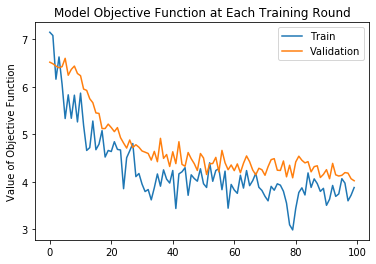

In [35]:
fig, ax = plt.subplots()
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Validation')
ax.legend(loc='best')
plt.ylabel('Value of Objective Function')
plt.title('Model Objective Function at Each Training Round')
plt.show()

### Plot Model Accuracy

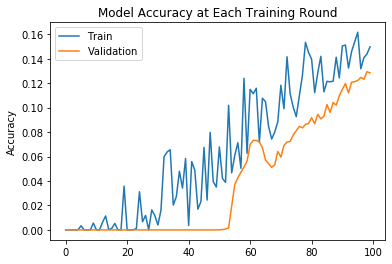

In [36]:
fig, ax = plt.subplots()
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Validation')
ax.legend(loc='best')
plt.ylabel('Accuracy')
plt.title('Model Accuracy at Each Training Round')
plt.show()

### Get Final Evaluation

In [37]:
keras_evaluate(server_state, val_data)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 191ms/step - loss: 4.0321 - num_tokens: 131351.0000 - num_tokens_no_oov: 127224.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1282 - accuracy_no_oov: 0.1164 - accuracy_no_oov_no_eos: 0.0726


### Generate Text

In [38]:
keras_model = build_model()
tff.learning.assign_weights_to_keras_model(keras_model, server_state.model)
print(generate_text(keras_model, "How are you today"))

how are you todaylike save dequeue guesses planning rendered improperly rectangles inference tryparse bear volatile game modifications ignoring process dx curves parenthesis a-za-z0-9 jetty interceptors wget mine sessions fortunately integer actor assumed nsmutablearray representation httpurlconnection mileage bot known mixture zone buffered crash fires tool in notifies uitableview inbetween code-behind sim fortunately integer blame


### Review Model Architecture

In [39]:
keras_model.summary()

Model: "model_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model1_input (InputLayer)    [(None, None)]            0         
_________________________________________________________________
model1_embedding (Embedding) (None, None, 100)         1000400   
_________________________________________________________________
model1_lstm (LSTM)           (None, None, 256)         365568    
_________________________________________________________________
dense_204 (Dense)            (None, None, 100)         25700     
_________________________________________________________________
dense_205 (Dense)            (None, None, 10004)       1010404   
Total params: 2,402,072
Trainable params: 2,402,072
Non-trainable params: 0
_________________________________________________________________
